In [1]:
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
from torchinfo import summary 
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import os

In [2]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


In [4]:
outputs_folder = "../data/saved_outputs"
folder_model = "same_parameter_real_optimized_function"
models_folder = f"../data/saved_models/{folder_model}"

if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
input_size = 2048
num_classes = 1000

batch_size = 256
num_epochs = 60

weight_decay_parameter = 1e-4
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 20
decay_rate = 0.1


In [5]:
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)

In [6]:
len(dataset)

1281167

In [7]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
  
    def forward(self, x): 
        out = self.linear(x) 
        return out 

In [8]:
# On définit le model
model = LogisticRegression(input_size=input_size, num_classes=num_classes) 
model = model.to(DEVICE)
summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
LogisticRegression                       [256, 1000]               --
├─Linear: 1-1                            [256, 1000]               2,049,000
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 524.54
Input size (MB): 2.10
Forward/backward pass size (MB): 2.05
Params size (MB): 8.20
Estimated Total Size (MB): 12.34

In [9]:
# milestones = []
# i = 1
# while (milestones[len(milestones)-1] if milestones != [] else 0) < num_epochs:
#     milestones.append(lr_decay_step*i+(milestones[len(milestones)-1] if milestones != [] else 0))
#     i += 1
# milestones = milestones[:len(milestones)-1] if milestones[len(milestones)-1] > 100 else milestones
# milestones

In [10]:
# Define the loss function and optimizer 
loss_function = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay_parameter)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=decay_rate)

In [11]:
# Train the model
correct_predictions=0
loss_history = []
true_loss_v1_history = []
true_loss_v2_history = []
accuracy_history = []
for epoch in range(num_epochs): 
    for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        
        # Move inputs and labels to the device 
        inputs = inputs.to(DEVICE) 
        labels = labels.to(DEVICE)
        
        # Forward pass 
        outputs = model(inputs) 
        loss = loss_function(outputs, labels)
        true_loss_v1 = loss.item() + weight_decay_parameter * sum(t.pow(2).sum().item() for t in model.state_dict().values()) / 2
        true_loss_v2 = loss.item() + weight_decay_parameter * model.state_dict()['linear.weight'].pow(2).sum().item() / 2
        
        _, predicted = torch.max(outputs, 1)

        # Ajout des prédictions correctes au total
        correct_predictions += (predicted == labels).sum().item()
        
        # Backward and optimize 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

    # update lr
    scheduler.step()

    # save intermediate models
    torch.save(model.state_dict(), f'{models_folder}/epoch-{epoch}.pt')

    # process accuracy
    accuracy = 100 * correct_predictions / len(dataset)
    correct_predictions=0
    
    print(f'>> Accuracy: {accuracy} %\n-- Loss: {loss.item()}\n-- True loss 1: {true_loss_v1}\n-- True loss 2: {true_loss_v2}')

    # save accuracy and loss
    loss_history.append(loss.item())
    accuracy_history.append(accuracy)
    true_loss_v1_history.append(true_loss_v1)
    true_loss_v2_history.append(true_loss_v2)    

Epoch [1/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.93it/s]


>> Accuracy: 9.087417955660737 %
-- Loss: 30.23968505859375
-- True loss 1: 46.67659874267578
-- True loss 2: 46.60204443359375


Epoch [2/60]: 100%|████████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.77it/s]


>> Accuracy: 55.73137615939218 %
-- Loss: 10.072610855102539
-- True loss 1: 21.26947885131836
-- True loss 2: 21.22918429260254


Epoch [3/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.87it/s]


>> Accuracy: 60.98861428681819 %
-- Loss: 7.3802995681762695
-- True loss 1: 15.796780281066894
-- True loss 2: 15.76426519317627


Epoch [4/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.73it/s]


>> Accuracy: 58.7516693764357 %
-- Loss: 6.889464855194092
-- True loss 1: 14.696361992645265
-- True loss 2: 14.665136730194092


Epoch [5/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.91it/s]


>> Accuracy: 55.517820861761194 %
-- Loss: 6.781591892242432
-- True loss 1: 14.886268039703369
-- True loss 2: 14.853428610992433


Epoch [6/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.81it/s]


>> Accuracy: 55.05004421749858 %
-- Loss: 6.734982013702393
-- True loss 1: 14.946373389434815
-- True loss 2: 14.913529669952393


Epoch [7/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.59it/s]


>> Accuracy: 55.391685861406046 %
-- Loss: 6.700133323669434
-- True loss 1: 14.888587968444824
-- True loss 2: 14.855291917419434


Epoch [8/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 108.14it/s]


>> Accuracy: 56.32606834237847 %
-- Loss: 6.7619547843933105
-- True loss 1: 14.793623137664795
-- True loss 2: 14.761021190643312


Epoch [9/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.33it/s]


>> Accuracy: 55.59251838362992 %
-- Loss: 6.795596122741699
-- True loss 1: 14.935420903015137
-- True loss 2: 14.902205497741699


Epoch [10/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.53it/s]


>> Accuracy: 55.81575235703074 %
-- Loss: 6.776031970977783
-- True loss 1: 14.902221851348877
-- True loss 2: 14.869255408477784


Epoch [11/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.03it/s]


>> Accuracy: 55.23628067223086 %
-- Loss: 6.815149307250977
-- True loss 1: 15.066932806396485
-- True loss 2: 15.033114932250976


Epoch [12/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.41it/s]


>> Accuracy: 55.50829829366507 %
-- Loss: 6.688011646270752
-- True loss 1: 14.895643775177003
-- True loss 2: 14.862321802520752


Epoch [13/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.97it/s]


>> Accuracy: 55.69469085607107 %
-- Loss: 6.696707725524902
-- True loss 1: 14.849779386901856
-- True loss 2: 14.816323350524902


Epoch [14/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.10it/s]


>> Accuracy: 55.97498218421174 %
-- Loss: 6.765446662902832
-- True loss 1: 14.860857594299317
-- True loss 2: 14.828007600402833


Epoch [15/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.54it/s]


>> Accuracy: 55.67377242779435 %
-- Loss: 6.68939733505249
-- True loss 1: 14.81659533920288
-- True loss 2: 14.78332233505249


Epoch [16/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.29it/s]


>> Accuracy: 55.60727055879522 %
-- Loss: 6.72731876373291
-- True loss 1: 14.873794181823731
-- True loss 2: 14.840716419982911


Epoch [17/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.35it/s]


>> Accuracy: 55.67416269697861 %
-- Loss: 6.711150169372559
-- True loss 1: 14.860718492126466
-- True loss 2: 14.82730173187256


Epoch [18/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.16it/s]


>> Accuracy: 55.58018587740708 %
-- Loss: 6.747411727905273
-- True loss 1: 14.905315112304688
-- True loss 2: 14.872196102905274


Epoch [19/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 106.01it/s]


>> Accuracy: 55.75487036428506 %
-- Loss: 6.716639041900635
-- True loss 1: 14.83805130996704
-- True loss 2: 14.804728104400635


Epoch [20/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.37it/s]


>> Accuracy: 55.57519043184846 %
-- Loss: 6.785477638244629
-- True loss 1: 14.969167112731935
-- True loss 2: 14.93599248199463


Epoch [21/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.14it/s]


>> Accuracy: 68.87509590865203 %
-- Loss: 1.6489081382751465
-- True loss 1: 8.74872699661255
-- True loss 2: 8.724161263275146


Epoch [22/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 114.59it/s]


>> Accuracy: 80.72226337393954 %
-- Loss: 1.9321283102035522
-- True loss 1: 8.20302235622406
-- True loss 2: 8.182842372703552


Epoch [23/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.78it/s]


>> Accuracy: 83.19571140998792 %
-- Loss: 1.8562268018722534
-- True loss 1: 7.424315369987488
-- True loss 2: 7.407034614372254


Epoch [24/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 119.10it/s]


>> Accuracy: 84.39961378961524 %
-- Loss: 1.7144584655761719
-- True loss 1: 6.669662197875977
-- True loss 2: 6.654536199951172


Epoch [25/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 118.05it/s]


>> Accuracy: 84.98181735870499 %
-- Loss: 1.5862133502960205
-- True loss 1: 6.00072555885315
-- True loss 2: 5.98730866279602


Epoch [26/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.84it/s]


>> Accuracy: 85.38371656466332 %
-- Loss: 1.4783087968826294
-- True loss 1: 5.4135801218032835
-- True loss 2: 5.40161582813263


Epoch [27/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.62it/s]


>> Accuracy: 85.57393376507513 %
-- Loss: 1.3843313455581665
-- True loss 1: 4.893658400154115
-- True loss 2: 4.882942673683166


Epoch [28/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.16it/s]


>> Accuracy: 85.76539982687659 %
-- Loss: 1.3032207489013672
-- True loss 1: 4.4339941940307614
-- True loss 2: 4.424401217651367


Epoch [29/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.98it/s]


>> Accuracy: 85.83869237968196 %
-- Loss: 1.2339160442352295
-- True loss 1: 4.027613661575318
-- True loss 2: 4.01900041923523


Epoch [30/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.49it/s]


>> Accuracy: 85.93134228402698 %
-- Loss: 1.1731711626052856
-- True loss 1: 3.6671858781814577
-- True loss 2: 3.659464912605286


Epoch [31/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.37it/s]


>> Accuracy: 85.91245325550845 %
-- Loss: 1.1204497814178467
-- True loss 1: 3.347580181503296
-- True loss 2: 3.340639039230347


Epoch [32/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.62it/s]


>> Accuracy: 85.93789880632268 %
-- Loss: 1.0709115266799927
-- True loss 1: 3.0609833906173707
-- True loss 2: 3.054754495429993


Epoch [33/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.12it/s]


>> Accuracy: 85.87373855242915 %
-- Loss: 1.0261821746826172
-- True loss 1: 2.805259358215332
-- True loss 2: 2.7996558074951174


Epoch [34/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.73it/s]


>> Accuracy: 85.83666297992377 %
-- Loss: 0.984626829624176
-- True loss 1: 2.576667620944977
-- True loss 2: 2.571636399936676


Epoch [35/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 120.35it/s]


>> Accuracy: 85.71380624071647 %
-- Loss: 0.9483069777488708
-- True loss 1: 2.374263902950287
-- True loss 2: 2.369736860561371


Epoch [36/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 119.21it/s]


>> Accuracy: 85.6041405999374 %
-- Loss: 0.9170965552330017
-- True loss 1: 2.1964340231895445
-- True loss 2: 2.192367844295502


Epoch [37/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 102.91it/s]


>> Accuracy: 85.42773892864865 %
-- Loss: 0.8921321630477905
-- True loss 1: 2.0417213064193724
-- True loss 2: 2.0380640966415404


Epoch [38/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.42it/s]


>> Accuracy: 85.26733829391485 %
-- Loss: 0.8737343549728394
-- True loss 1: 1.9094438779830933
-- True loss 2: 1.9061593549728395


Epoch [39/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.13it/s]


>> Accuracy: 85.02466891513753 %
-- Loss: 0.8627763390541077
-- True loss 1: 1.7984177968025208
-- True loss 2: 1.7954644249916076


Epoch [40/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.75it/s]


>> Accuracy: 84.79300512735654 %
-- Loss: 0.8592918515205383
-- True loss 1: 1.707938152599335
-- True loss 2: 1.7052839413642884


Epoch [41/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.88it/s]


>> Accuracy: 87.79729730784511 %
-- Loss: 0.5888626575469971
-- True loss 1: 1.4272764600753785
-- True loss 2: 1.424611583328247


Epoch [42/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.72it/s]


>> Accuracy: 88.88482141672397 %
-- Loss: 0.5698768496513367
-- True loss 1: 1.398616374874115
-- True loss 2: 1.3959505801200867


Epoch [43/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.28it/s]


>> Accuracy: 89.4802941380788 %
-- Loss: 0.5561695694923401
-- True loss 1: 1.3755528584480285
-- True loss 2: 1.372895692539215


Epoch [44/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.61it/s]


>> Accuracy: 89.78712377074963 %
-- Loss: 0.5455535054206848
-- True loss 1: 1.355795939731598
-- True loss 2: 1.3531539937019348


Epoch [45/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.42it/s]


>> Accuracy: 89.96532068028603 %
-- Loss: 0.5369656085968018
-- True loss 1: 1.3382374172210694
-- True loss 2: 1.3356149250030518


Epoch [46/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.49it/s]


>> Accuracy: 90.0719422214278 %
-- Loss: 0.5297878980636597
-- True loss 1: 1.322238500404358
-- True loss 2: 1.3196381910324098


Epoch [47/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.36it/s]


>> Accuracy: 90.13977100565344 %
-- Loss: 0.5236203670501709
-- True loss 1: 1.307386208343506
-- True loss 2: 1.304809917831421


Epoch [48/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 116.10it/s]


>> Accuracy: 90.18293477743339 %
-- Loss: 0.518187403678894
-- True loss 1: 1.2933978090286256
-- True loss 2: 1.290846827507019


Epoch [49/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.89it/s]


>> Accuracy: 90.21602960425925 %
-- Loss: 0.5133147239685059
-- True loss 1: 1.2800948583602905
-- True loss 2: 1.277570095062256


Epoch [50/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.94it/s]


>> Accuracy: 90.24256790878941 %
-- Loss: 0.5088752508163452
-- True loss 1: 1.2673446592330933
-- True loss 2: 1.2648467351913453


Epoch [51/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.41it/s]


>> Accuracy: 90.25739813779155 %
-- Loss: 0.5047894716262817
-- True loss 1: 1.255066410636902
-- True loss 2: 1.2525957216262817


Epoch [52/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 120.81it/s]


>> Accuracy: 90.27987764280535 %
-- Loss: 0.5009701251983643
-- True loss 1: 1.24317004737854
-- True loss 2: 1.2407268146514894


Epoch [53/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 105.31it/s]


>> Accuracy: 90.29517619482863 %
-- Loss: 0.49740174412727356
-- True loss 1: 1.2316369049549103
-- True loss 2: 1.2292212265491487


Epoch [54/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.72it/s]


>> Accuracy: 90.31031863917819 %
-- Loss: 0.4940677881240845
-- True loss 1: 1.2204489768981934
-- True loss 2: 1.2180608545303344


Epoch [55/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.16it/s]


>> Accuracy: 90.3255391373646 %
-- Loss: 0.4909338355064392
-- True loss 1: 1.209570452785492
-- True loss 2: 1.2072098120689394


Epoch [56/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 105.12it/s]


>> Accuracy: 90.34005715101934 %
-- Loss: 0.48797154426574707
-- True loss 1: 1.1989716083526611
-- True loss 2: 1.196638341140747


Epoch [57/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:07<00:00, 74.41it/s]


>> Accuracy: 90.35090663434197 %
-- Loss: 0.4851624667644501
-- True loss 1: 1.1886319991588592
-- True loss 2: 1.18632594332695


Epoch [58/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:58<00:00, 85.04it/s]


>> Accuracy: 90.36472216346503 %
-- Loss: 0.48248013854026794
-- True loss 1: 1.1785235929012299
-- True loss 2: 1.176244591665268


Epoch [59/60]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.77it/s]


>> Accuracy: 90.37611802364563 %
-- Loss: 0.479850709438324
-- True loss 1: 1.168571097278595
-- True loss 2: 1.166318971157074


Epoch [60/60]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 131.92it/s]

>> Accuracy: 90.38642113011028 %
-- Loss: 0.47732436656951904
-- True loss 1: 1.158824118423462
-- True loss 2: 1.156598682975769


In [12]:
torch.save(accuracy_history, f'{models_folder}/accuracy.pt')
torch.save(loss_history, f'{models_folder}/loss.pt')
torch.save(true_loss_v1_history, f'{models_folder}/true_loss_v1.pt')
torch.save(true_loss_v2_history, f'{models_folder}/true_loss_v2.pt')

In [13]:
# acc = torch.load('../data/saved_models/constant_step_lr/accuracy.pt')
# loss = torch.load('../data/saved_models/constant_step_lr/loss.pt')
# params20 = torch.load('../data/saved_models/constant_step_lr/epoch-20.pt')
# params40 = torch.load('../data/saved_models/constant_step_lr/epoch-40.pt')

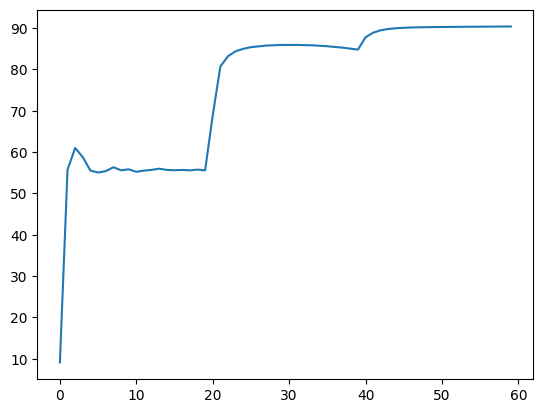

In [14]:
plt.plot(accuracy_history)

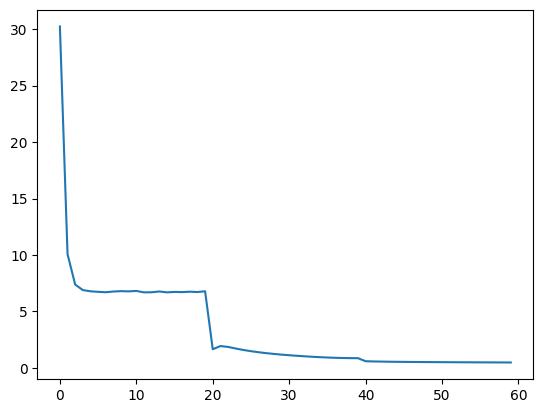

In [15]:
plt.plot(loss_history)

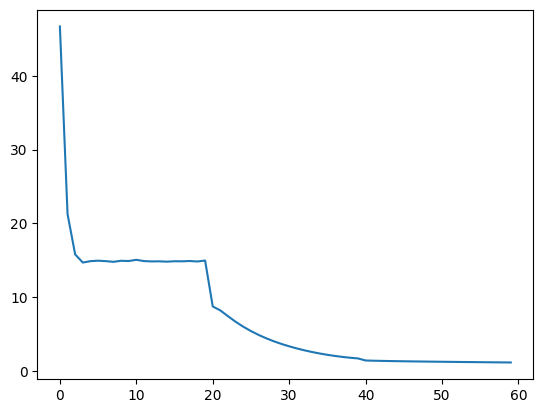

In [16]:
plt.plot(true_loss_v1_history)

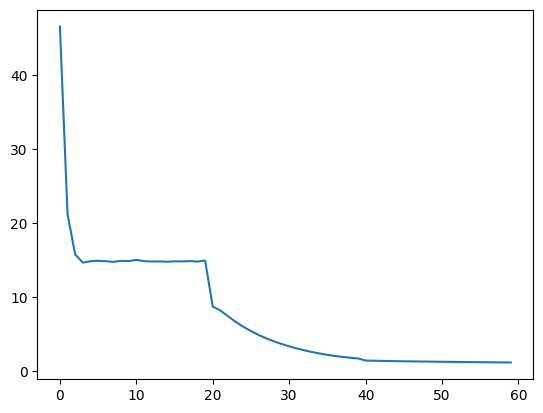

In [17]:
plt.plot(true_loss_v2_history)